In [1]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [4]:
def adaptive_kdj_factor(df, volatility_window=20):
    # 1. 增加价格过滤 - 避免在低波动期产生噪音
    returns = np.log(df['close']).diff()
    vol = returns.rolling(volatility_window, min_periods=1).std()
    vol = np.where(np.isinf(vol), np.nan, vol)  # 替换 inf
    vol = pd.Series(vol, index=df.index).ffill().bfill().fillna(0.01)
    
    # 2. 优化自适应逻辑 - 引入非线性缩放
    scaled_vol = (vol * 100).clip(5, 20)
    # 增加对高波动市场的敏感性
    n_period = np.where(scaled_vol > 15, 
                        scaled_vol * 1.4, 
                        scaled_vol * 0.6)
    n_period = np.clip(n_period, 5, 25).astype(int)
    
    # 3. 改进极值计算 - 增加权重衰减
    periods = list(range(5, 26))  # 5到25
    min_vals = []
    max_vals = []
    
    for p in periods:
        # 指数衰减加权最小值
        min_roll = df['low'].rolling(p, min_periods=1).min()
        min_ewm = min_roll.ewm(span=max(1, p//2), adjust=False).mean()
        min_vals.append(min_ewm)
        
        # 指数衰减加权最大值
        max_roll = df['high'].rolling(p, min_periods=1).max()
        max_ewm = max_roll.ewm(span=max(1, p//2), adjust=False).mean()
        max_vals.append(max_ewm)
    
    min_df = pd.DataFrame(dict(zip(periods, min_vals)), index=df.index)
    max_df = pd.DataFrame(dict(zip(periods, max_vals)), index=df.index)
    
    # 4. 动态选择窗口
    col_idx = (n_period - 5).clip(0, 20)
    row_idx = np.arange(len(df))
    low_min = min_df.values[row_idx, col_idx]
    high_max = max_df.values[row_idx, col_idx]
    
    # 5. 改进RSV计算 - 避免除以零
    denom = high_max - low_min
    # 使用 NumPy 的 where 替代 Pandas 的 replace
    denom = np.where(denom < 1e-5, 1e-5, denom)  # 避免除以零
    
    # 6. 改进RSV计算 - 增加平滑处理
    rsv = 100 * (df['close'].values - low_min) / denom
    rsv = np.clip(rsv, 0, 100)  # 限制在0-100范围内
    rsv = pd.Series(rsv, index=df.index).fillna(50)  # 填充缺失值为50
    
    # 7. 双EMA平滑
    fast_k = rsv.ewm(span=2, adjust=False, min_periods=1).mean()
    slow_k = fast_k.ewm(span=3, adjust=False, min_periods=1).mean()
    
    # 8. 改进中心化方法 - 使用滚动中位数避免极端值影响
    rolling_median = slow_k.rolling(100, min_periods=1).median().shift(1).fillna(50)
    
    # 9. 最终因子构建 - 添加方向控制和归一化
    factor = (slow_k - rolling_median)
    
    # 10. 增加趋势强化 - 结合动量方向
    momentum = df['close'].pct_change(3).fillna(0)
    factor = factor * (1 + np.sign(momentum) * 0.2)
    
    # 11. 最终归一化处理
    abs_mean = factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    factor = factor / abs_mean
    
    return factor

# 新加入的五个因子
def trend_correlation_factor(df, window=20):
    time_index = np.arange(window)
    factor = df['close'].rolling(window).apply(
        lambda x: np.corrcoef(x, time_index)[0,1] if len(x) == window else np.nan, 
        raw=True
    )
    return factor

def rsi_factor(df, period=20):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def adaptive_kdj_factor_v2(df, volatility_window=20):
    # Calculate log returns safely
    returns = np.log(df['close']).diff()
    
    # Calculate rolling volatility with min_periods to avoid initial NaNs
    vol = returns.rolling(volatility_window, min_periods=1).std()
    
    # Handle any remaining NaNs/Infs robustly
    vol = vol.replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(0.01)
    
    # Convert to integer period between 5 and 20
    n_period = (vol * 100).clip(5, 20).astype(int)
    
    # Precompute rolling min/max for all required periods
    periods = list(range(5, 21))
    min_df = pd.DataFrame({p: df['low'].rolling(p, min_periods=1).min() for p in periods})
    max_df = pd.DataFrame({p: df['high'].rolling(p, min_periods=1).max() for p in periods})
    
    # Extract appropriate values using vectorized operations
    col_idx = (n_period - 5).values
    row_idx = np.arange(len(df))
    low_min = min_df.values[row_idx, col_idx]
    high_max = max_df.values[row_idx, col_idx]
    
    # Compute RSV safely
    denom = high_max - low_min
    rsv = 100 * (df['close'].values - low_min) / np.where(denom < 1e-8, np.nan, denom)
    rsv = pd.Series(rsv, index=df.index).fillna(50.0)  # Neutral value when denom≈0
    
    # Compute K-line (EMA of RSV)
    K = rsv.ewm(span=3, adjust=False, min_periods=1).mean()
    
    # Center using expanding mean without look-ahead bias
    mean_so_far = K.expanding().mean().shift(1).fillna(50.0)
    return K - mean_so_far

def kdj_pressure_factor(df, n=9, m=3):
    low_min = df['low'].rolling(n).min()
    high_max = df['high'].rolling(n).max()
    rsv = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-8)
    K = rsv.ewm(alpha=1/m, adjust=False).mean()
    D = K.ewm(alpha=1/m, adjust=False).mean()
    J = 3*K - 2*D
    # Normalized pressure score: positive = overbought, negative = oversold
    return (K + D + J)/3 - 50

def j_extreme_factor(df, n=9, m=3):
    low_min = df['low'].rolling(n).min()
    high_max = df['high'].rolling(n).max()
    rsv = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-8)
    K = rsv.ewm(alpha=1/m, adjust=False).mean()
    D = K.ewm(alpha=1/m, adjust=False).mean()
    J = 3*K - 2*D
    # Sigmoid transformation to emphasize extremes
    return 1 / (1 + np.exp(-0.1*(J - 50)))

def macd(df, fast=12, slow=26, signal=9):
    # Calculate MACD, filling NaN with 0
    ema_fast = df['close'].ewm(span=fast, adjust=False).mean()
    ema_slow = df['close'].ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    return macd_line.fillna(0)

def atr(df, period=14):
    # Calculate ATR, filling NaN with 0
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr_value = true_range.rolling(period, min_periods=1).mean()
    return atr_value.fillna(0)

def optimize_weights(df, factors, target):
    # Create feature matrix X from factors
    X = pd.DataFrame({name: factor(df) for name, factor in factors.items()})
    y = target(df)
    # Remove rows with NaN in X or y
    valid_rows = X.notna().all(axis=1) & y.notna()
    X = X.loc[valid_rows]
    y = y.loc[valid_rows]
    # Check if there's enough data to fit the model
    if len(X) == 0:
        raise ValueError("No valid data remaining after removing NaN values.")
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_

def improved_factor(df):
    # 1. 计算原始因子
    adaptive_kdj = adaptive_kdj_factor(df)
    buy_pressure = df['taker_buy_turnover'] / df['turnover'].replace(0, np.nan).fillna(0)
    macd_diff = macd(df)
    atr_value = atr(df)
    
    # 2. 计算新加入的五个因子
    trend_corr = trend_correlation_factor(df)
    rsi = rsi_factor(df)
    adaptive_kdj_v2 = adaptive_kdj_factor_v2(df)
    kdj_pressure = kdj_pressure_factor(df)
    j_extreme = j_extreme_factor(df)
    
    # 3. 标准化所有因子（处理NaN）
    factors_to_standardize = {
        'adaptive_kdj': adaptive_kdj,
        'buy_pressure': buy_pressure,
        'macd_diff': macd_diff,
        'atr': atr_value,
        'trend_corr': trend_corr,
        'rsi': rsi,
        'adaptive_kdj_v2': adaptive_kdj_v2,
        'kdj_pressure': kdj_pressure,
        'j_extreme': j_extreme
    }
    
    standardized_factors = {}
    for name, factor_series in factors_to_standardize.items():
        # 处理特殊情况：j_extreme因子范围在0-1之间，需要特殊处理
        if name == 'j_extreme':
            # 将0-1范围映射到-1到1范围
            factor_series = 2 * (factor_series - 0.5)
        
        # 标准化处理
        mean_val = factor_series.mean()
        std_val = factor_series.std()
        if std_val < 1e-5:
            standardized_factor = factor_series - mean_val
        else:
            standardized_factor = (factor_series - mean_val) / std_val
        
        # 填充NaN为0
        standardized_factors[name] = standardized_factor.fillna(0)
    
    # 4. 定义因子字典和目标函数
    factors = {
        'adaptive_kdj': lambda df: standardized_factors['adaptive_kdj'],
        'buy_pressure': lambda df: standardized_factors['buy_pressure'],
        'macd_diff': lambda df: standardized_factors['macd_diff'],
        'atr': lambda df: -standardized_factors['atr'],  # 负ATR惩罚高波动性
        'trend_corr': lambda df: standardized_factors['trend_corr'],
        'rsi': lambda df: standardized_factors['rsi'],
        'adaptive_kdj_v2': lambda df: standardized_factors['adaptive_kdj_v2'],
        'kdj_pressure': lambda df: standardized_factors['kdj_pressure'],
        'j_extreme': lambda df: standardized_factors['j_extreme']
    }
    
    # 目标函数：未来10期收益率
    target = lambda df: df['close'].pct_change(10).shift(-10)
    
    # 5. 优化权重
    weights = optimize_weights(df, factors, target)
    
    # 6. 组合因子
    combined_factor = sum(weight * factor(df) for weight, factor in zip(weights, factors.values()))
    
    # 7. 最终归一化处理
    abs_mean = combined_factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    normalized_factor = combined_factor / abs_mean
    
    return normalized_factor

In [5]:
evaluator.set_factor(
    factor_data_or_func=improved_factor,
    factor_name='improved_factor'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.011339
   Rank_IC (Spearman): -0.007735
📊 信息比率:
   IR: 0.118440
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130379
   因子列: improved_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


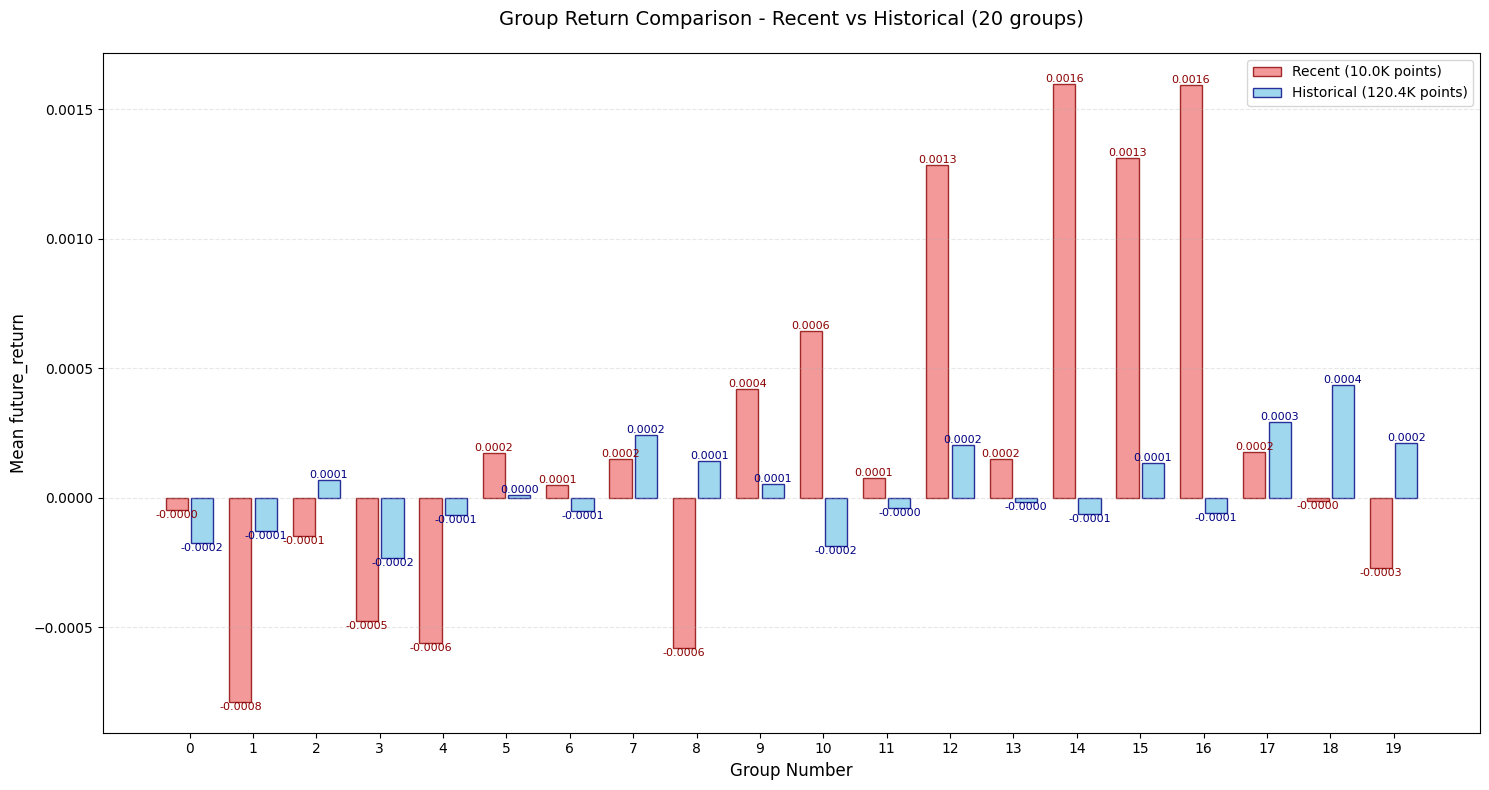

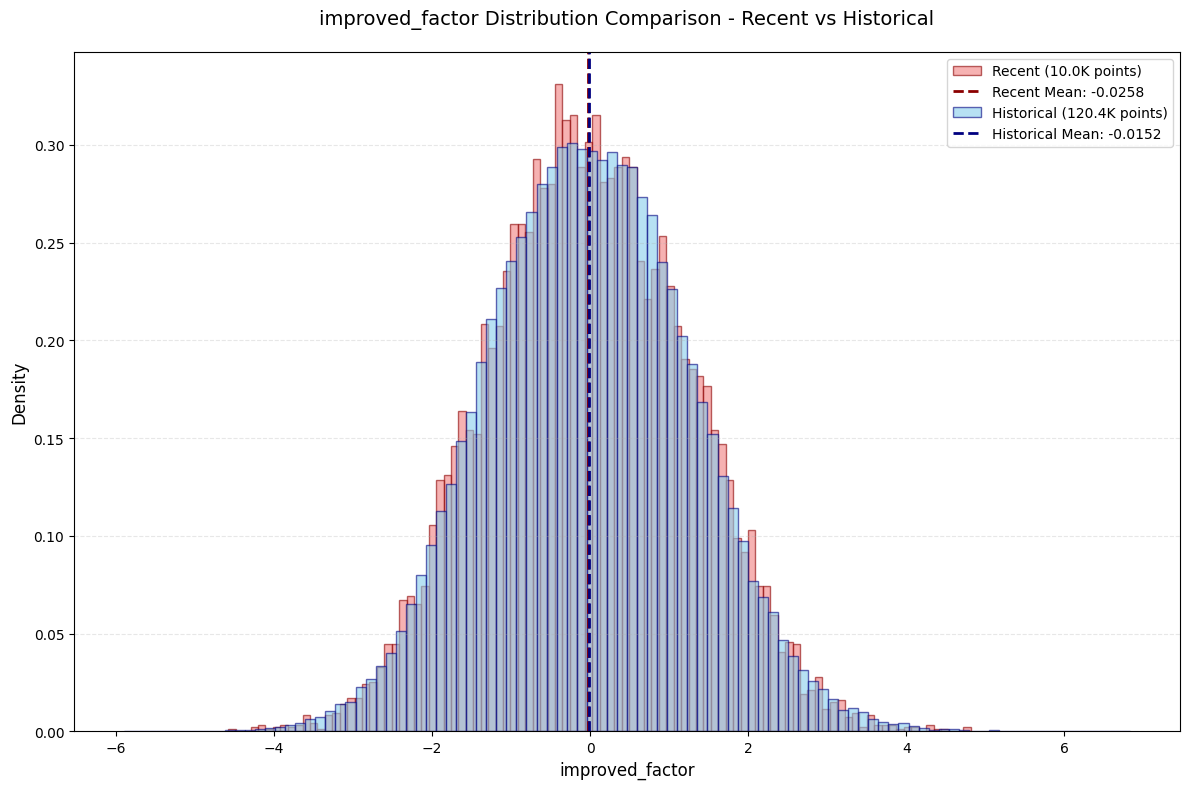

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [6]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)